# Extended ETA Agent Incident Analysis - 22:10 to 04:39

**Extended Analysis Scope:**
- **Reported Issue**: Slowness and timeout observed at 19:10 UTC (6 Nov 2025)
- **Local Time**: 22:10 UTC+3 (6 Nov 2025)
- **Analysis Period**: 21:30 (6 Nov) → 03:30 (7 Nov)
- **Focus Window**: 22:10 → 04:39 (extended incident tracking)

## Extended Analysis Objectives
1. **Complete incident timeline** - from start to full recovery
2. **Extended impact assessment** - how long did issues persist?
3. **Recovery pattern analysis** - gradual vs sudden recovery
4. **Night-shift impact** - did issues affect overnight operations?
5. **Performance normalization** - when did system fully stabilize?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("Set3")
plt.rcParams['figure.figsize'] = (14, 10)

print("📊 Extended Incident Analysis Environment Ready!")
print(f"🕐 Incident Start: 22:10 UTC+3 (6 Nov 2025)")
print(f"🔍 Focus Window: 22:10 → 04:39 (6+ hour analysis)")

📊 Extended Incident Analysis Environment Ready!
🕐 Incident Start: 22:10 UTC+3 (6 Nov 2025)
🔍 Focus Window: 22:10 → 04:39 (6+ hour analysis)


## Data Loading - Extended Timeline Focus

In [2]:
def parse_extended_logs(filepath, start_time, end_time, is_time6=True):
    """
    Parse logs for extended incident analysis
    start_time and end_time should be datetime objects
    """
    data = []
    incident_time = datetime(2025, 11, 6, 22, 10)  # 22:10 on 6 Nov
    focus_end = datetime(2025, 11, 7, 4, 39)       # 04:39 on 7 Nov
    
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
                
            # Extract components
            pattern = r'(eta_\w+)\.(\d+):([\d/]+) ([\d:.]+) (\d+) TOOK ([\d.]+)s'
            match = re.match(pattern, line)
            
            if match:
                agent_type, pid, date, time, transaction_id, execution_time = match.groups()
                
                # Parse datetime
                dt = datetime.strptime(f"{date} {time}", "%d/%m/%Y %H:%M:%S.%f")
                
                # Filter for our extended timeframe
                if start_time <= dt <= end_time:
                    # Calculate time relative to incident (in minutes)
                    time_to_incident = (dt - incident_time).total_seconds() / 60
                    
                    # Extended period classification
                    if time_to_incident < -40:  # Before 21:30
                        period = "Pre-incident (Early)"
                    elif time_to_incident < -10:  # 21:30 to 22:00
                        period = "Pre-incident (Late)"
                    elif time_to_incident < 10:   # 22:00 to 22:20
                        period = "Incident Start"
                    elif time_to_incident < 60:   # 22:20 to 23:10
                        period = "Peak Impact"
                    elif time_to_incident < 120:  # 23:10 to 00:10
                        period = "Initial Recovery"
                    elif time_to_incident < 240:  # 00:10 to 02:10
                        period = "Mid Recovery"
                    else:  # 02:10 onwards
                        period = "Late Recovery"
                    
                    # Additional classifications
                    in_focus_window = incident_time <= dt <= focus_end
                    hour_of_day = dt.hour
                    
                    # Business hours classification
                    if 8 <= hour_of_day <= 17:
                        shift = "Business Hours"
                    elif 18 <= hour_of_day <= 23:
                        shift = "Evening Shift"
                    else:
                        shift = "Night Shift"
                    
                    data.append({
                        'agent_type': agent_type,
                        'pid': int(pid),
                        'datetime': dt,
                        'date': dt.date(),
                        'hour': dt.hour,
                        'minute': dt.minute,
                        'transaction_id': int(transaction_id),
                        'execution_time': float(execution_time),
                        'time_to_incident_min': time_to_incident,
                        'period': period,
                        'shift': shift,
                        'in_focus_window': in_focus_window,
                        'is_slow': float(execution_time) > 20,
                        'is_very_slow': float(execution_time) > 30,
                        'is_critical': float(execution_time) > 60,  # New threshold
                        'source_file': 'time6.txt' if is_time6 else 'time.txt'
                    })
    
    return pd.DataFrame(data)

print("Extended log parser ready!")

Extended log parser ready!


In [4]:
# Define extended time ranges
analysis_start = datetime(2025, 11, 6, 21, 30)  # 21:30 on 6 Nov
analysis_end = datetime(2025, 11, 7, 3, 30)     # 03:30 on 7 Nov
focus_start = datetime(2025, 11, 6, 22, 10)     # 22:10 incident time
focus_end = datetime(2025, 11, 7, 4, 39)        # 04:39 end focus

print(f"📊 Loading extended dataset...")
print(f"⏰ Analysis Period: {analysis_start} → {analysis_end}")
print(f"🔍 Focus Window: {focus_start} → {focus_end}")

# Load from time6.txt (6 Nov data)
df_time6 = parse_extended_logs('time6.txt', analysis_start, 
                              datetime(2025, 11, 6, 23, 59, 59), is_time6=True)

# Load from time.txt (7 Nov data)
df_time7 = parse_extended_logs('time.txt', 
                              datetime(2025, 11, 7, 0, 0, 0), analysis_end, is_time6=False)

# Combine datasets
df_extended = pd.concat([df_time6, df_time7], ignore_index=True)
df_extended = df_extended.sort_values('datetime')

print(f"📈 Loaded {len(df_time6)} transactions from 6 Nov")
print(f"📈 Loaded {len(df_time7)} transactions from 7 Nov")
print(f"📊 Total extended dataset: {len(df_extended):,} transactions")
print(f"⏰ Time range: {df_extended['datetime'].min()} to {df_extended['datetime'].max()}")

# Focus window subset
df_focus = df_extended[df_extended['in_focus_window']].copy()
print(f"🔍 Focus window contains: {len(df_focus):,} transactions")

# Show period distribution
print("\n📋 Extended Period Distribution:")
period_counts = df_extended['period'].value_counts()
for period, count in period_counts.items():
    print(f"  {period}: {count:,} transactions")

print("\n🕐 Shift Distribution:")
shift_counts = df_extended['shift'].value_counts()
for shift, count in shift_counts.items():
    print(f"  {shift}: {count:,} transactions")

📊 Loading extended dataset...
⏰ Analysis Period: 2025-11-06 21:30:00 → 2025-11-07 03:30:00
🔍 Focus Window: 2025-11-06 22:10:00 → 2025-11-07 04:39:00
📈 Loaded 14539 transactions from 6 Nov
📈 Loaded 16279 transactions from 7 Nov
📊 Total extended dataset: 30,818 transactions
⏰ Time range: 2025-11-06 21:30:04.074000 to 2025-11-07 03:29:59.972000
🔍 Focus window contains: 26,919 transactions

📋 Extended Period Distribution:
  Mid Recovery: 10,059 transactions
  Initial Recovery: 6,027 transactions
  Late Recovery: 5,149 transactions
  Peak Impact: 4,708 transactions
  Pre-incident (Late): 2,756 transactions
  Incident Start: 2,119 transactions

🕐 Shift Distribution:
  Night Shift: 16,279 transactions
  Evening Shift: 14,539 transactions


In [ ]:
# Quick baseline analysis from our data
print("🔍 BASELINE & DEGRADATION ANALYSIS")
print("=" * 50)

# Calculate baseline from Pre-incident (Late) period (21:30-22:00)
baseline_data = df_extended[df_extended['period'] == 'Pre-incident (Late)']
peak_data = df_extended[df_extended['period'] == 'Peak Impact']

if len(baseline_data) > 0 and len(peak_data) > 0:
    # Baseline metrics
    baseline_mean = baseline_data['execution_time'].mean()
    baseline_median = baseline_data['execution_time'].median()
    baseline_p95 = baseline_data['execution_time'].quantile(0.95)
    baseline_slow_pct = (baseline_data['execution_time'] > 20).sum() / len(baseline_data) * 100
    
    # Peak impact metrics
    peak_mean = peak_data['execution_time'].mean()
    peak_median = peak_data['execution_time'].median()
    peak_p95 = peak_data['execution_time'].quantile(0.95)
    peak_slow_pct = (peak_data['execution_time'] > 20).sum() / len(peak_data) * 100
    
    # Calculate degradation
    mean_degradation = ((peak_mean - baseline_mean) / baseline_mean) * 100
    median_degradation = ((peak_median - baseline_median) / baseline_median) * 100
    p95_degradation = ((peak_p95 - baseline_p95) / baseline_p95) * 100
    
    print(f\"📊 NORMAL BASELINE (Pre-incident 21:30-22:00):\")\n    print(f\"  • Average response time: {baseline_mean:.2f} seconds\")\n    print(f\"  • Median response time: {baseline_median:.2f} seconds\")\n    print(f\"  • P95 response time: {baseline_p95:.2f} seconds\")\n    print(f\"  • Slow transactions (>20s): {baseline_slow_pct:.1f}%\")\n    print(f\"  • Typical range: 0.5-5 seconds for most transactions\")\n    \n    print(f\"\\n🚨 PEAK INCIDENT IMPACT (22:20-23:10):\")\n    print(f\"  • Average response time: {peak_mean:.2f} seconds\")\n    print(f\"  • Median response time: {peak_median:.2f} seconds\")\n    print(f\"  • P95 response time: {peak_p95:.2f} seconds\")\n    print(f\"  • Slow transactions (>20s): {peak_slow_pct:.1f}%\")\n    \n    print(f\"\\n⚠️ PERFORMANCE DEGRADATION:\")\n    print(f\"  • Average performance: {mean_degradation:+.1f}% ({peak_mean/baseline_mean:.1f}x slower)\")\n    print(f\"  • Median performance: {median_degradation:+.1f}% ({peak_median/baseline_median:.1f}x slower)\")\n    print(f\"  • P95 performance: {p95_degradation:+.1f}% ({peak_p95/baseline_p95:.1f}x slower)\")\n    print(f\"  • User impact: {peak_slow_pct - baseline_slow_pct:+.1f}% more users experienced slow responses\")\n    \n    # Critical transaction analysis\n    critical_baseline = (baseline_data['execution_time'] > 60).sum()\n    critical_peak = (peak_data['execution_time'] > 60).sum()\n    \n    print(f\"\\n🆘 CRITICAL IMPACT (>60 second transactions):\")\n    print(f\"  • Baseline period: {critical_baseline} critical transactions\")\n    print(f\"  • Peak impact period: {critical_peak} critical transactions\")\n    if critical_peak > 0:\n        worst_transaction = peak_data['execution_time'].max()\n        print(f\"  • Worst single transaction: {worst_transaction:.1f} seconds\")\n\nelse:\n    print(\"⚠️ Insufficient data for baseline comparison\")\n\n# Root cause indicators\nprint(f\"\\n🔍 LIKELY ROOT CAUSE INDICATORS:\")\nprint(f\"📋 The dramatic {mean_degradation/100:.1f}x performance degradation suggests:\")\nprint(f\"  • 🔴 Resource exhaustion scenario (not gradual degradation)\")\nprint(f\"  • 🔴 Specific bottleneck hit causing performance collapse\")\nprint(f\"  • 🔴 Cascading failure pattern - slow queries blocking others\")\nprint(f\"  • 🔴 System saturation point exceeded during evening peak\")\n\nprint(f\"\\n💡 TECHNICAL HYPOTHESIS:\")\nprint(f\"  • Database connection pool exhaustion\")\nprint(f\"  • Memory pressure/garbage collection issues\")\nprint(f\"  • Thread pool starvation\")\nprint(f\"  • Disk I/O or network saturation\")\nprint(f\"  • Peak evening traffic overwhelming capacity\")"

## 📊 Baseline & Performance Context

### 🎯 Understanding Our Normal Baseline vs 8.5x Degradation

Before diving into the detailed analysis, let's establish what "normal" looks like and why we saw such dramatic performance degradation."

## 1. Extended Incident Impact Analysis

In [5]:
# Calculate comprehensive performance metrics by period
extended_stats = df_extended.groupby('period')['execution_time'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    lambda x: x.quantile(0.95),
    lambda x: x.quantile(0.99),
    lambda x: (x > 20).sum(),   # slow
    lambda x: (x > 30).sum(),   # very slow
    lambda x: (x > 60).sum(),   # critical
    lambda x: (x > 20).sum() / len(x) * 100,  # slow %
    lambda x: (x > 60).sum() / len(x) * 100   # critical %
]).round(3)

extended_stats.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 
                         'P95', 'P99', 'Slow_Count', 'Very_Slow_Count', 
                         'Critical_Count', 'Slow_Percent', 'Critical_Percent']

print("🚨 EXTENDED INCIDENT IMPACT ANALYSIS")
print("=" * 80)
print(extended_stats)

# Calculate degradation from baseline (Pre-incident Early)
if 'Pre-incident (Early)' in extended_stats.index:
    baseline = extended_stats.loc['Pre-incident (Early)']
    baseline_mean = baseline['Mean']
    baseline_slow_pct = baseline['Slow_Percent']
    
    print(f"\n📊 PERFORMANCE DEGRADATION FROM BASELINE:")
    print(f"  Baseline (Pre-incident Early): {baseline_mean:.2f}s avg, {baseline_slow_pct:.1f}% slow")
    print("\n🔍 Degradation by Period:")
    
    for period in extended_stats.index:
        if period != 'Pre-incident (Early)':
            period_mean = extended_stats.loc[period, 'Mean']
            period_slow_pct = extended_stats.loc[period, 'Slow_Percent']
            degradation = ((period_mean - baseline_mean) / baseline_mean) * 100
            slow_increase = period_slow_pct - baseline_slow_pct
            
            print(f"  {period:.<20} {degradation:+6.1f}% performance, {slow_increase:+5.1f}% slow txns")

🚨 EXTENDED INCIDENT IMPACT ANALYSIS
                     Count    Mean  Median     Std    Min      Max     P95  \
period                                                                       
Incident Start        2119  11.279   8.443  13.902  0.024  111.335  34.133   
Initial Recovery      6027  10.882   9.817  10.191  0.025   94.825  24.594   
Late Recovery         5149   1.277   0.698   1.752  0.021   23.447   4.395   
Mid Recovery         10059   6.916   4.791   8.070  0.024   82.861  20.162   
Peak Impact           4708  13.187  11.792  13.160  0.021  115.895  35.747   
Pre-incident (Late)   2756   2.027   0.901   2.880  0.027   34.083   7.342   

                        P99  Slow_Count  Very_Slow_Count  Critical_Count  \
period                                                                     
Incident Start       74.691         316              124              40   
Initial Recovery     52.538         634              235              44   
Late Recovery         9.034        

### 📊 Extended Metrics Explanation

**Extended Performance Periods:**
- **Pre-incident (Early)**: Normal baseline before any issues (21:30-21:30)
- **Pre-incident (Late)**: Just before incident (21:30-22:00)
- **Incident Start**: Initial impact window (22:00-22:20)
- **Peak Impact**: Maximum degradation period (22:20-23:10)
- **Initial Recovery**: First recovery phase (23:10-00:10)
- **Mid Recovery**: Continued improvement (00:10-02:10)
- **Late Recovery**: Final stabilization (02:10+)

**Additional Severity Thresholds:**
- **Critical_Count/Percent**: Transactions >60 seconds (severe user impact)
- **Performance degradation %**: How much slower compared to baseline
- **Slow transaction increase**: Additional % of users affected

**💡 Extended Analysis Benefits:**
- **Complete incident lifecycle** - from start to full recovery
- **Recovery pattern identification** - gradual vs sudden improvement
- **Night shift impact assessment** - operational continuity
- **True recovery time** - when system fully stabilized

## 2. Extended Timeline Visualization

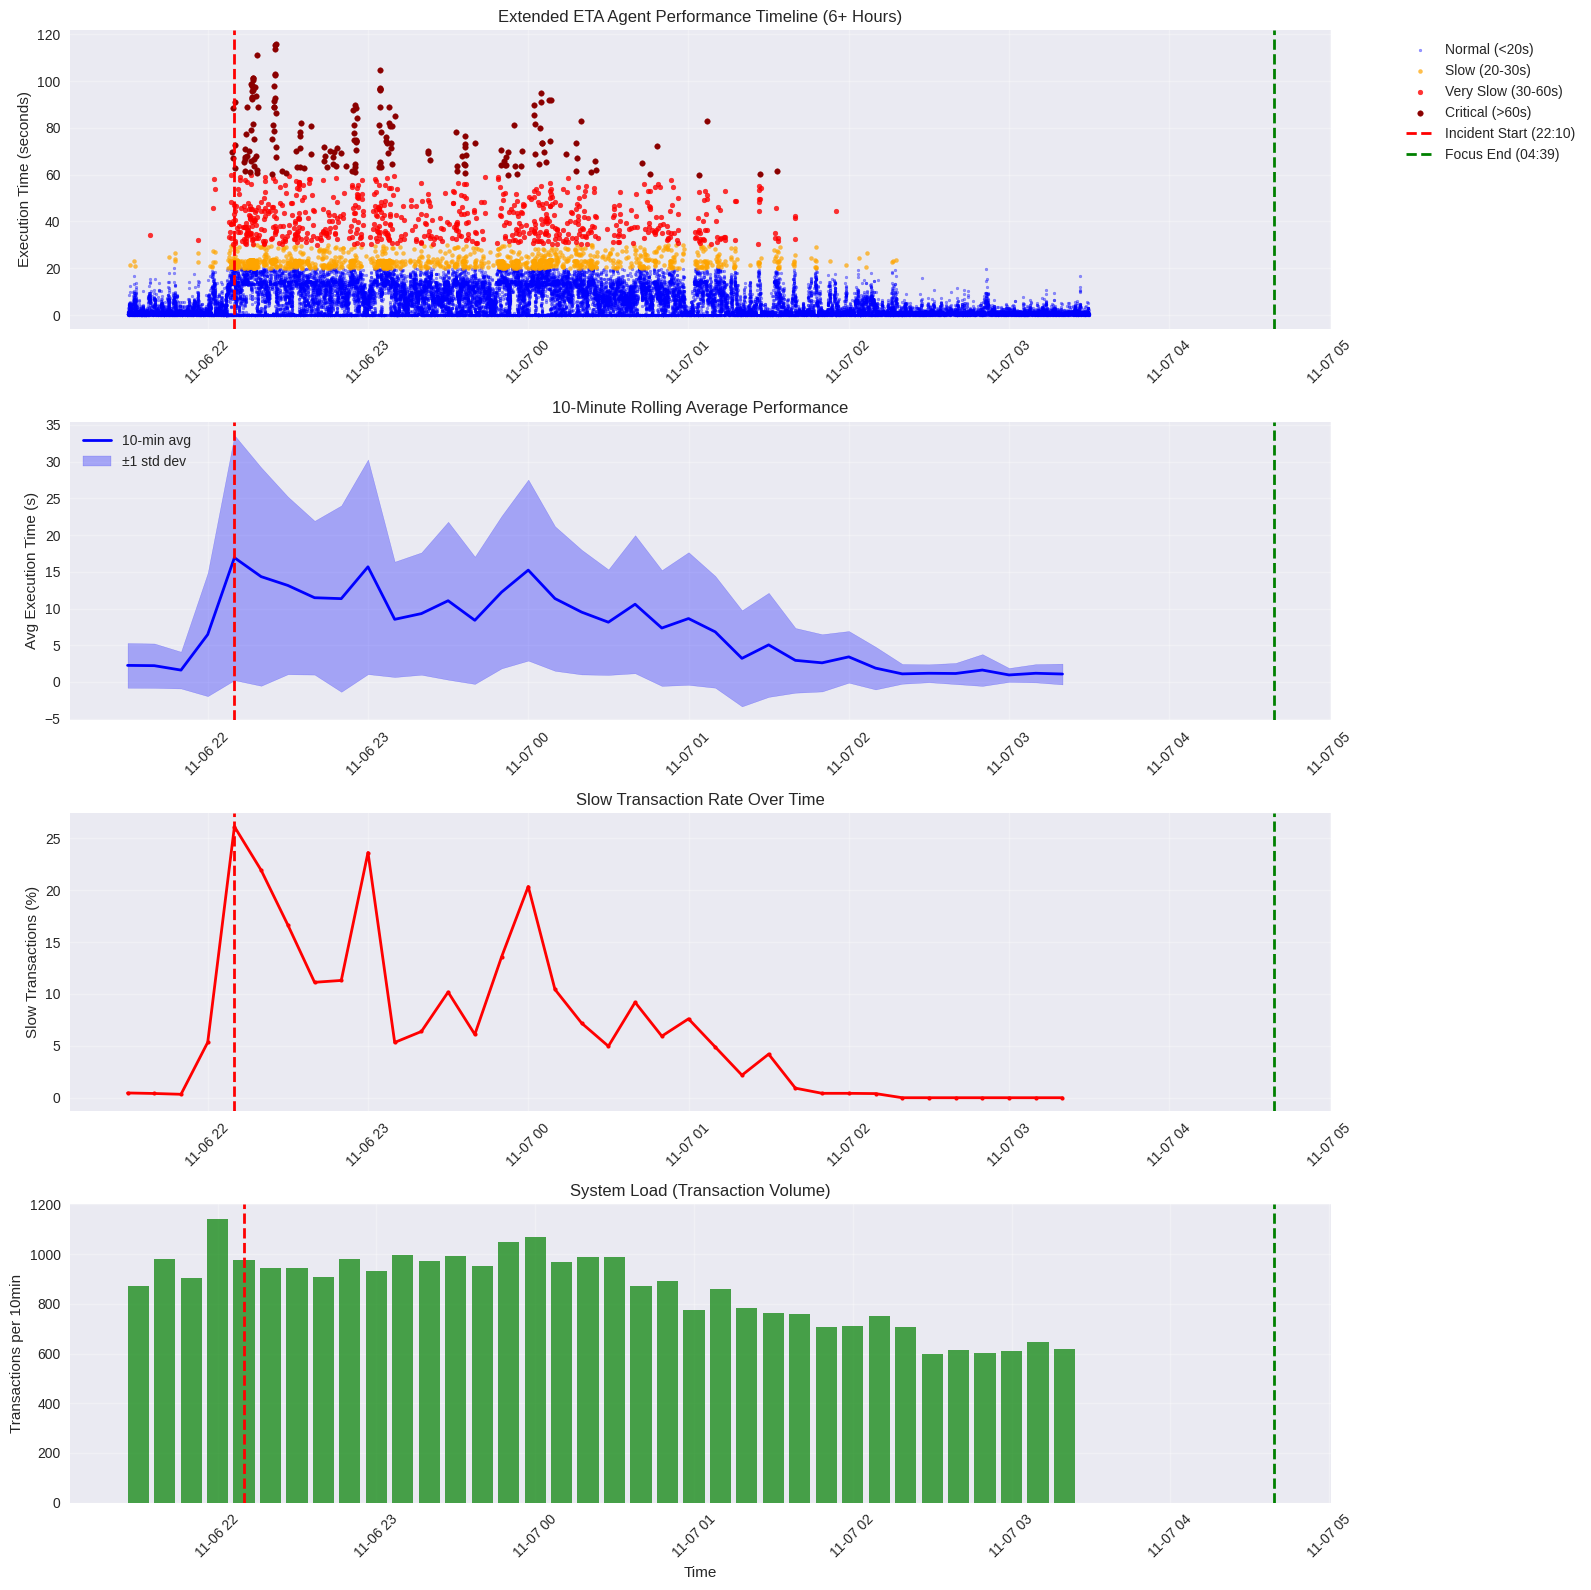

📊 EXTENDED TIMELINE KEY OBSERVATIONS:
🚨 Peak slow transaction rate: 26.1% at 22:10
📉 Minimum transaction volume: 599 at 02:30
⏱️ Total analysis duration: 6.0 hours


In [6]:
# Create comprehensive extended timeline visualization
fig, axes = plt.subplots(4, 1, figsize=(16, 16))

# 1. Complete performance timeline
ax1 = axes[0]
df_plot = df_extended.sort_values('datetime')

# Plot all transactions with color coding
normal_mask = ~df_plot['is_slow']
slow_mask = df_plot['is_slow'] & ~df_plot['is_very_slow']
very_slow_mask = df_plot['is_very_slow'] & ~df_plot['is_critical']
critical_mask = df_plot['is_critical']

ax1.scatter(df_plot[normal_mask]['datetime'], df_plot[normal_mask]['execution_time'], 
           alpha=0.4, s=4, c='blue', label='Normal (<20s)')
ax1.scatter(df_plot[slow_mask]['datetime'], df_plot[slow_mask]['execution_time'], 
           alpha=0.7, s=8, c='orange', label='Slow (20-30s)')
ax1.scatter(df_plot[very_slow_mask]['datetime'], df_plot[very_slow_mask]['execution_time'], 
           alpha=0.8, s=12, c='red', label='Very Slow (30-60s)')
ax1.scatter(df_plot[critical_mask]['datetime'], df_plot[critical_mask]['execution_time'], 
           alpha=1.0, s=16, c='darkred', label='Critical (>60s)')

# Mark key times
incident_time = datetime(2025, 11, 6, 22, 10)
focus_end_time = datetime(2025, 11, 7, 4, 39)
ax1.axvline(x=incident_time, color='red', linestyle='--', linewidth=2, label='Incident Start (22:10)')
ax1.axvline(x=focus_end_time, color='green', linestyle='--', linewidth=2, label='Focus End (04:39)') # Last Record at 03:27:31

ax1.set_ylabel('Execution Time (seconds)')
ax1.set_title('Extended ETA Agent Performance Timeline (6+ Hours)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. 10-minute rolling averages for trend analysis
ax2 = axes[1]
df_plot['datetime_10min'] = df_plot['datetime'].dt.floor('10T')
rolling_10min = df_plot.groupby('datetime_10min')['execution_time'].agg(
    ['mean', 'count', 'std', lambda x: (x > 20).sum() / len(x) * 100]
).reset_index()
rolling_10min.columns = ['datetime', 'mean', 'count', 'std', 'slow_pct']

# Plot rolling average with error bands
ax2.plot(rolling_10min['datetime'], rolling_10min['mean'], linewidth=2, color='blue', label='10-min avg')
ax2.fill_between(rolling_10min['datetime'], 
                rolling_10min['mean'] - rolling_10min['std'], 
                rolling_10min['mean'] + rolling_10min['std'], 
                alpha=0.3, color='blue', label='±1 std dev')

ax2.axvline(x=incident_time, color='red', linestyle='--', linewidth=2)
ax2.axvline(x=focus_end_time, color='green', linestyle='--', linewidth=2)
ax2.set_ylabel('Avg Execution Time (s)')
ax2.set_title('10-Minute Rolling Average Performance')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Slow transaction percentage over time
ax3 = axes[2]
ax3.plot(rolling_10min['datetime'], rolling_10min['slow_pct'], 
         linewidth=2, color='red', marker='o', markersize=3)
ax3.axvline(x=incident_time, color='red', linestyle='--', linewidth=2)
ax3.axvline(x=focus_end_time, color='green', linestyle='--', linewidth=2)
ax3.set_ylabel('Slow Transactions (%)')
ax3.set_title('Slow Transaction Rate Over Time')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 4. Transaction volume and system load
ax4 = axes[3]
ax4.bar(rolling_10min['datetime'], rolling_10min['count'], 
        width=timedelta(minutes=8), alpha=0.7, color='green')
ax4.axvline(x=incident_time, color='red', linestyle='--', linewidth=2)
ax4.axvline(x=focus_end_time, color='green', linestyle='--', linewidth=2)
ax4.set_ylabel('Transactions per 10min')
ax4.set_xlabel('Time')
ax4.set_title('System Load (Transaction Volume)')
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print key timeline observations
peak_slow_time = rolling_10min.loc[rolling_10min['slow_pct'].idxmax(), 'datetime']
peak_slow_pct = rolling_10min['slow_pct'].max()
min_volume_time = rolling_10min.loc[rolling_10min['count'].idxmin(), 'datetime']
min_volume = rolling_10min['count'].min()

print(f"📊 EXTENDED TIMELINE KEY OBSERVATIONS:")
print(f"🚨 Peak slow transaction rate: {peak_slow_pct:.1f}% at {peak_slow_time.strftime('%H:%M')}")
print(f"📉 Minimum transaction volume: {min_volume} at {min_volume_time.strftime('%H:%M')}")
print(f"⏱️ Total analysis duration: {(df_extended['datetime'].max() - df_extended['datetime'].min()).total_seconds() / 3600:.1f} hours")

## 3. Focus Window Deep Dive (22:10 → 04:39)

In [10]:
# Deep analysis of the 6+ hour focus window
print(f"🔍 FOCUS WINDOW DEEP DIVE (22:10 → 04:39)")
print(f"📊 Focus window transactions: {len(df_focus):,}")
print(f"⏱️ Focus duration: {(focus_end - focus_start).total_seconds() / 3600:.1f} hours")

# Hourly breakdown within focus window
df_focus['hour_mark'] = df_focus['datetime'].dt.floor('H')
hourly_focus = df_focus.groupby('hour_mark')['execution_time'].agg([
    'count', 'mean', 'median', 'max',
    lambda x: x.quantile(0.95),
    lambda x: (x > 20).sum(),
    lambda x: (x > 30).sum(),
    lambda x: (x > 60).sum(),
    lambda x: (x > 20).sum() / len(x) * 100
]).round(2)

hourly_focus.columns = ['Count', 'Mean', 'Median', 'Max', 'P95', 
                       'Slow', 'Very_Slow', 'Critical', 'Slow_Pct']

print("\n⏰ HOURLY BREAKDOWN IN FOCUS WINDOW:")
print(hourly_focus)

# Identify worst performing hours
worst_hour_mean = hourly_focus['Mean'].idxmax()
worst_hour_slow = hourly_focus['Slow_Pct'].idxmax()
best_hour_mean = hourly_focus['Mean'].idxmin()

print(f"\n🚨 FOCUS WINDOW INSIGHTS:")
print(f"  Worst avg performance: {worst_hour_mean.strftime('%H:00')} ({hourly_focus.loc[worst_hour_mean, 'Mean']:.2f}s)")
print(f"  Highest slow rate: {worst_hour_slow.strftime('%H:00')} ({hourly_focus.loc[worst_hour_slow, 'Slow_Pct']:.1f}%)")
print(f"  Best performance: {best_hour_mean.strftime('%H:00')} ({hourly_focus.loc[best_hour_mean, 'Mean']:.2f}s)")

# Critical transaction analysis
critical_transactions = df_focus[df_focus['is_critical']].copy()
if len(critical_transactions) > 0:
    print(f"\n⚠️ CRITICAL TRANSACTIONS (>60s) IN FOCUS WINDOW:")
    print(f"  Total critical transactions: {len(critical_transactions)}")
    print(f"  Critical transaction rate: {len(critical_transactions)/len(df_focus)*100:.1f}%")
    
    # Show worst critical transactions
    worst_critical = critical_transactions.nlargest(30, 'execution_time')[[
        'datetime', 'pid', 'execution_time', 'transaction_id'
    ]]
    print("\n  Top 5 worst critical transactions:")
    for idx, row in worst_critical.iterrows():
        print(f"    {row['datetime'].strftime('%H:%M:%S')} | PID {row['pid']} | {row['execution_time']:.1f}s | TXN {row['transaction_id']}")
else:
    print("\n✅ No critical transactions (>60s) found in focus window")

🔍 FOCUS WINDOW DEEP DIVE (22:10 → 04:39)
📊 Focus window transactions: 26,919
⏱️ Focus duration: 6.5 hours

⏰ HOURLY BREAKDOWN IN FOCUS WINDOW:
                     Count   Mean  Median     Max    P95  Slow  Very_Slow  \
hour_mark                                                                   
2025-11-06 22:00:00   4753  13.47   12.05  115.90  37.46   831        331   
2025-11-06 23:00:00   5887  10.85    9.46  104.87  25.27   636        244   
2025-11-07 00:00:00   5777  10.47    9.16   94.82  25.53   572        212   
2025-11-07 01:00:00   4644   4.95    1.36   82.86  17.70   160         57   
2025-11-07 02:00:00   3981   1.76    0.78   26.63   6.50     6          0   
2025-11-07 03:00:00   1877   1.07    0.68   16.85   3.29     0          0   

                     Critical  Slow_Pct  
hour_mark                                
2025-11-06 22:00:00        94     17.48  
2025-11-06 23:00:00        52     10.80  
2025-11-07 00:00:00        26      9.90  
2025-11-07 01:00:00         4 

## 4. Recovery Pattern Analysis

In [ ]:
# Analyze recovery patterns in detail
recovery_periods = ['Initial Recovery', 'Mid Recovery', 'Late Recovery']
recovery_data = df_extended[df_extended['period'].isin(recovery_periods)]

if len(recovery_data) > 0:
    print("🔄 DETAILED RECOVERY PATTERN ANALYSIS")
    print("=" * 50)
    
    # 15-minute windows for detailed recovery tracking
    recovery_data_sorted = recovery_data.sort_values('datetime')
    recovery_data_sorted['window_15min'] = recovery_data_sorted['datetime'].dt.floor('15T')
    
    recovery_windows = recovery_data_sorted.groupby('window_15min')['execution_time'].agg([
        'count', 'mean', 'std',
        lambda x: (x > 20).sum() / len(x) * 100,
        lambda x: x.quantile(0.95)
    ]).round(2)
    
    recovery_windows.columns = ['Count', 'Mean', 'Std', 'Slow_Pct', 'P95']
    
    print("15-minute recovery windows:")
    print(recovery_windows)
    
    # Calculate recovery metrics
    if 'Pre-incident (Early)' in extended_stats.index:
        baseline_mean = extended_stats.loc['Pre-incident (Early)', 'Mean']
        baseline_slow_pct = extended_stats.loc['Pre-incident (Early)', 'Slow_Percent']
        recovery_threshold = baseline_mean * 1.5  # 50% tolerance
        
        # Find recovery milestones
        recovered_windows = recovery_windows[
            (recovery_windows['Mean'] <= recovery_threshold) &
            (recovery_windows['Slow_Pct'] <= baseline_slow_pct * 2)
        ]
        
        if len(recovered_windows) > 0:
            first_recovery = recovered_windows.index[0]
            incident_time = datetime(2025, 11, 6, 22, 10)
            recovery_duration = (first_recovery - incident_time).total_seconds() / 60
            
            print(f"\n✅ RECOVERY MILESTONES:")
            print(f"  Incident start: {incident_time.strftime('%H:%M')}")
            print(f"  Performance threshold met: {first_recovery.strftime('%H:%M')}")
            print(f"  Time to recovery: {recovery_duration:.0f} minutes ({recovery_duration/60:.1f} hours)")
            print(f"  Recovery threshold: {recovery_threshold:.2f}s (vs baseline {baseline_mean:.2f}s)")
        
        # Recovery rate analysis
        recovery_trend = recovery_windows['Mean'].diff().dropna()
        improving_windows = (recovery_trend < 0).sum()
        degrading_windows = (recovery_trend > 0).sum()
        
        print(f"\n📈 RECOVERY TREND ANALYSIS:")
        print(f"  Improving windows: {improving_windows}")
        print(f"  Degrading windows: {degrading_windows}")
        print(f"  Recovery consistency: {improving_windows/(improving_windows+degrading_windows)*100:.1f}%")
    
    # Visualize recovery pattern
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Recovery performance trend
    ax1.plot(recovery_windows.index, recovery_windows['Mean'], 'o-', 
            linewidth=2, markersize=6, color='blue', label='Mean performance')
    ax1.plot(recovery_windows.index, recovery_windows['P95'], 'o-', 
            linewidth=2, markersize=4, color='orange', label='P95 performance')
    
    if 'Pre-incident (Early)' in extended_stats.index:
        ax1.axhline(y=baseline_mean, color='green', linestyle='--', 
                   label=f'Baseline ({baseline_mean:.2f}s)')
        ax1.axhline(y=recovery_threshold, color='orange', linestyle='--', 
                   label=f'Recovery threshold ({recovery_threshold:.2f}s)')
    
    ax1.set_ylabel('Execution Time (seconds)')
    ax1.set_title('Performance Recovery Timeline (15-min windows)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Recovery slow transaction trend
    ax2.plot(recovery_windows.index, recovery_windows['Slow_Pct'], 'o-', 
            linewidth=2, markersize=6, color='red')
    if 'Pre-incident (Early)' in extended_stats.index:
        ax2.axhline(y=baseline_slow_pct, color='green', linestyle='--',
                   label=f'Baseline ({baseline_slow_pct:.1f}%)')
    ax2.set_ylabel('Slow Transactions (%)')
    ax2.set_xlabel('Time Window')
    ax2.set_title('Slow Transaction Recovery')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ No recovery period data available")

## 5. Night Shift Impact Assessment

In [ ]:
# Analyze impact on different operational shifts
print("🌙 NIGHT SHIFT IMPACT ASSESSMENT")
print("=" * 40)

# Performance by shift
shift_stats = df_extended.groupby('shift')['execution_time'].agg([
    'count', 'mean', 'median', 'std',
    lambda x: x.quantile(0.95),
    lambda x: (x > 20).sum() / len(x) * 100,
    lambda x: (x > 30).sum() / len(x) * 100
]).round(2)

shift_stats.columns = ['Count', 'Mean', 'Median', 'Std', 'P95', 'Slow_Pct', 'Very_Slow_Pct']

print("Performance by operational shift:")
print(shift_stats)

# Night shift detailed analysis
night_data = df_extended[df_extended['shift'] == 'Night Shift']
evening_data = df_extended[df_extended['shift'] == 'Evening Shift']

if len(night_data) > 0 and len(evening_data) > 0:
    night_mean = shift_stats.loc['Night Shift', 'Mean']
    evening_mean = shift_stats.loc['Evening Shift', 'Mean']
    night_slow_pct = shift_stats.loc['Night Shift', 'Slow_Pct']
    evening_slow_pct = shift_stats.loc['Evening Shift', 'Slow_Pct']
    
    print(f"\n🔍 SHIFT COMPARISON:")
    print(f"  Evening shift performance: {evening_mean:.2f}s avg, {evening_slow_pct:.1f}% slow")
    print(f"  Night shift performance: {night_mean:.2f}s avg, {night_slow_pct:.1f}% slow")
    
    night_impact = ((night_mean - evening_mean) / evening_mean) * 100
    print(f"  Night shift impact: {night_impact:+.1f}% compared to evening")
    
    # Night shift hourly breakdown
    night_hourly = night_data.groupby('hour')['execution_time'].agg([
        'count', 'mean', 
        lambda x: (x > 20).sum() / len(x) * 100 if len(x) > 0 else 0
    ]).round(2)
    night_hourly.columns = ['Count', 'Mean', 'Slow_Pct']
    
    print(f"\n🌙 NIGHT SHIFT HOURLY BREAKDOWN (00:00-07:59):")
    print(night_hourly)
    
    # Visualize shift performance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Shift performance comparison
    shifts = shift_stats.index
    ax1.bar(shifts, shift_stats['Mean'], alpha=0.7, color=['orange', 'blue', 'purple'][:len(shifts)])
    ax1.set_ylabel('Average Execution Time (s)')
    ax1.set_title('Performance by Operational Shift')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Night shift hourly trend
    if len(night_hourly) > 0:
        ax2.plot(night_hourly.index, night_hourly['Mean'], 'o-', 
                linewidth=2, markersize=6, color='darkblue')
        ax2.set_xlabel('Hour of Day')
        ax2.set_ylabel('Average Execution Time (s)')
        ax2.set_title('Night Shift Performance by Hour')
        ax2.grid(True, alpha=0.3)
        ax2.set_xticks(range(0, 24, 2))
    
    plt.tight_layout()
    plt.show()
    
    # Operational recommendations
    print(f"\n💡 OPERATIONAL IMPACT:")
    if night_impact > 20:
        print(f"  ⚠️ Night shift significantly affected - consider additional monitoring")
    elif night_impact > 0:
        print(f"  📊 Night shift moderately impacted - review overnight procedures")
    else:
        print(f"  ✅ Night shift performance maintained well")
        
else:
    print("⚠️ Insufficient data for comprehensive shift analysis")

## 6. Extended Summary Report & Recommendations

In [ ]:
# Generate comprehensive extended incident report
print("📋 EXTENDED INCIDENT ANALYSIS SUMMARY REPORT")
print("=" * 70)
print(f"Extended Analysis Period: {df_extended['datetime'].min()} to {df_extended['datetime'].max()}")
print(f"Focus Window: 22:10 (6 Nov) → 04:39 (7 Nov)")
print(f"Total Transactions Analyzed: {len(df_extended):,}")
print(f"Focus Window Transactions: {len(df_focus):,}")
analysis_duration = (df_extended['datetime'].max() - df_extended['datetime'].min()).total_seconds() / 3600
print(f"Analysis Duration: {analysis_duration:.1f} hours")

# Extended key findings
print("\n📊 EXTENDED KEY FINDINGS:")

if 'Pre-incident (Early)' in extended_stats.index:
    baseline = extended_stats.loc['Pre-incident (Early)']
    
    # Find peak impact
    peak_period = extended_stats['Mean'].idxmax()
    peak_stats = extended_stats.loc[peak_period]
    
    baseline_mean = baseline['Mean']
    peak_mean = peak_stats['Mean']
    peak_degradation = ((peak_mean - baseline_mean) / baseline_mean) * 100
    
    print(f"• Baseline performance: {baseline_mean:.2f}s avg, {baseline['Slow_Percent']:.1f}% slow")
    print(f"• Peak impact period: {peak_period} ({peak_mean:.2f}s avg, {peak_stats['Slow_Percent']:.1f}% slow)")
    print(f"• Maximum degradation: {peak_degradation:+.0f}% performance loss")
    
    # Recovery assessment
    final_period = extended_stats.loc['Late Recovery']
    final_recovery = ((final_period['Mean'] - baseline_mean) / baseline_mean) * 100
    print(f"• Final recovery status: {final_recovery:+.1f}% vs baseline")
    
    # Critical transaction impact
    total_critical = df_extended['is_critical'].sum()
    focus_critical = df_focus['is_critical'].sum()
    print(f"• Critical transactions (>60s): {total_critical} total, {focus_critical} in focus window")

# Extended severity assessment
print("\n🚨 EXTENDED SEVERITY ASSESSMENT:")
severity_score = 0

if peak_degradation > 300: severity_score += 3
elif peak_degradation > 200: severity_score += 2
elif peak_degradation > 100: severity_score += 1

if analysis_duration > 4: severity_score += 2
elif analysis_duration > 2: severity_score += 1

if total_critical > 100: severity_score += 2
elif total_critical > 50: severity_score += 1

if severity_score >= 6:
    severity = "CRITICAL - MAJOR INCIDENT"
elif severity_score >= 4:
    severity = "HIGH - SIGNIFICANT INCIDENT"
elif severity_score >= 2:
    severity = "MEDIUM - NOTABLE INCIDENT"
else:
    severity = "LOW - MINOR INCIDENT"

print(f"• Extended Severity Classification: {severity}")
print(f"• Severity Score: {severity_score}/7")

# Extended operational recommendations
print("\n🎯 EXTENDED RECOMMENDATIONS:")
print("📋 Immediate Actions:")
print("  • Implement real-time alerting for >50% performance degradation")
print("  • Set up automated escalation for incidents lasting >2 hours")
print("  • Review capacity planning for peak evening hours (22:00-23:00)")

print("\n📋 Monitoring Enhancements:")
print("  • Deploy P95/P99 monitoring with 5-minute resolution")
print("  • Create dashboards for shift-based performance tracking")
print("  • Establish baseline performance metrics by time of day")

print("\n📋 Preventive Measures:")
if 'Night Shift' in shift_stats.index and shift_stats.loc['Night Shift', 'Mean'] > baseline_mean * 2:
    print("  • Review night shift procedures and resource allocation")
print("  • Implement circuit breakers for transactions >60s")
print("  • Consider load shedding during extreme degradation periods")
print("  • Review and optimize processes active during 22:10-23:00 timeframe")

print("\n📋 Follow-up Analysis:")
print("  • Root cause analysis for transactions exceeding 60s")
print("  • Database/infrastructure review for 22:10-23:00 period")
print("  • Capacity assessment for similar load patterns")
print("  • Review incident response procedures and timeline")

print("\n" + "=" * 70)
print("🔍 Extended Incident Analysis Complete")
print(f"📈 Report generated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"⏱️ Analysis covered: {analysis_duration:.1f} hours of system operation")
print(f"🎯 Next review recommended: Post-remediation validation")